In [1]:
# google drive code
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
!ls MyDrive/ | grep archive

archive.zip


In [3]:
# keep the extracted file in colab's environment to not pollute your google drive
%cp MyDrive/archive.zip ../

In [4]:
%cd ../
!unzip archive.zip

/
Archive:  archive.zip
   creating: archive/
  inflating: __MACOSX/._archive      
   creating: archive/fer2013/
  inflating: __MACOSX/archive/._fer2013  
  inflating: archive/Submission.csv  
  inflating: __MACOSX/archive/._Submission.csv  
   creating: archive/fer2013/fer2013/
  inflating: __MACOSX/archive/fer2013/._fer2013  
  inflating: archive/fer2013/fer2013/fer2013.csv  
  inflating: __MACOSX/archive/fer2013/fer2013/._fer2013.csv  
  inflating: archive/fer2013/fer2013/fer2013.bib  
  inflating: __MACOSX/archive/fer2013/fer2013/._fer2013.bib  
  inflating: archive/fer2013/fer2013/README  
  inflating: __MACOSX/archive/fer2013/fer2013/._README  


In [5]:
!ls | grep archive

archive
archive.zip


In [6]:
#------------------ if you see archive and archive.zip you cant start running the code below--------------

In [7]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00


we will show forward pass by hand . because we have to use a pretrained model to make good enough classification

In [8]:
import numpy as np, pandas as pd
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.utils as utils
import einops

from torchvision.transforms import transforms
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
fer = pd.read_csv("./archive/fer2013/fer2013/fer2013.csv")
fer[:2] # show first 2 examples

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [10]:
fer_train = fer[fer.Usage == "Training"]
fer_valid = fer[fer.Usage == "PublicTest"]
fer_test = fer[fer.Usage == "PrivateTest"]

fer_train.shape ,fer_valid.shape, fer_test.shape

((28709, 3), (3589, 3), (3589, 3))

In [101]:
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16
        else:
            self.transforms = transformations

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)


        label = self.data.iloc[idx]['emotion']


        return image, torch.tensor(label) # dont use capital Tensor it will convert it into float



In [102]:
train_data = FerDataset(fer_train,"train")
# the data loader not the dataset adds a channels dimension but we can just squeeze it out. in our model class
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=3)

for Xb,yb in train_loader:
    print(Xb.shape , yb.shape)
    break

torch.Size([3, 1, 32, 32]) torch.Size([3])


# generating patches

In [103]:
xb = einops.asnumpy(Xb)

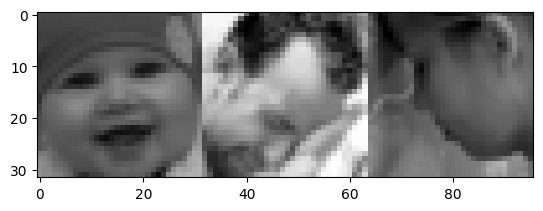

In [104]:
plt.imshow(einops.rearrange(xb,"b 1 h w -> h (b w)"), cmap="gray")

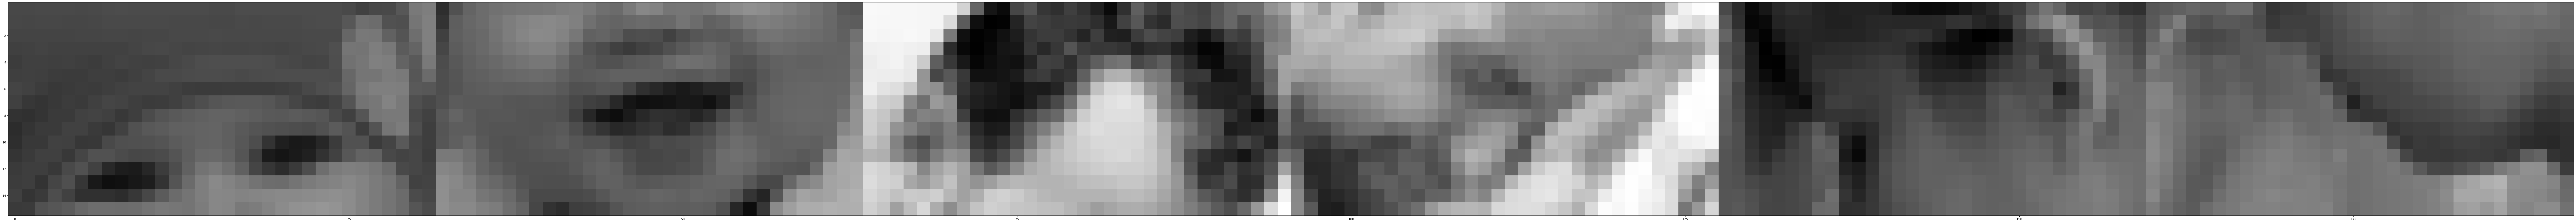

In [105]:
# now what we want is to turn them into patches
# patches = einops.rearrange(xb,"b 1 (p1 h) (p2 w) -> b (p1 p2) (h w)",p1=2,p2=2)
patches = einops.rearrange(xb,"b 1 (p1 h) (p2 w) -> h (b p1 p2 w)",p1=2,p2=2) # increase p1,p2 to get 16 x 16 patches
# here p1 and p2 must be 14 x 14
plt.figure(figsize=(150,80))
plt.imshow(patches, cmap="gray")
plt.show()

(3, 4, 256)


<Axes: >

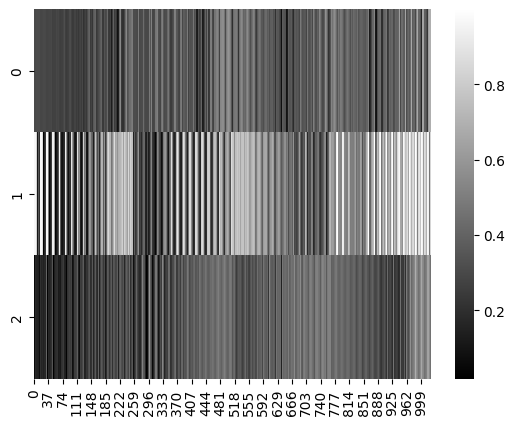

In [106]:
# now what we need is to flatten these patches
flat_patch = einops.rearrange(xb,"b 1 (p1 h) (p2 w) -> b (p1 p2) (h w)",p1=2,p2=2)
print(flat_patch.shape) # 16 x 16 -> 256
sns.heatmap(einops.rearrange(flat_patch,"b p hw ->b (p hw) "),cmap="gray")


# patch embeddings

In [107]:
# now we wont plot anythoing so we will convert it back to torch array
flat_patch = torch.tensor(flat_patch)
print( flat_patch.shape)
# patch embeddings
# now each patch 16 x 16 (matrix) gets a (n_embed dimensional) row vector representation
n_embed = 128
patch_embedding = torch.randn(256, n_embed)
xb = einops.einsum(flat_patch,patch_embedding,"b p hw , hw n_embed -> b p n_embed")
xb.shape, type(xb)

torch.Size([3, 4, 256])


(torch.Size([3, 4, 128]), torch.Tensor)

# class token embeddings we wont use this in our model
but we show how the forward pass looks here

In [108]:
# its like adding an extra patch . but this patch is learnable
learnable_patch = torch.randn(1,n_embed)
# add same learnable patch to all the images in the batch
learnable_patch = einops.repeat(learnable_patch,"1 n_embed -> 3 1 n_embed")
print(learnable_patch.shape)
# you actually need all dims except one to be different to pack or concat it
# in the paper they add it at the first location. (dont really see how it matters if append it at the end instead)
xb ,ps = einops.pack([learnable_patch,xb],"b * n_embed") # we want to append it on top of patch
xb.shape

torch.Size([3, 1, 128])


torch.Size([3, 5, 128])

# now we add position embedding

In [109]:
# since each patch is considered as a token . each patch must get a positional learning information
# therefore the shape is b, num_patch + 1, D. (+1 for cls embedding)

pos_embedding = torch.randn(1,5,n_embed)
xb = xb + pos_embedding
xb.shape

torch.Size([3, 5, 128])

# now we make our self attention blocks.. (for our transformer)

In [110]:
# check the cell below for unit test for our implementation
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,n_embed=128,head_size=8):
        super().__init__()
        # single head
        self.head_size = torch.tensor(head_size)
        self.n_embed = torch.tensor(n_embed)
        self.Q = nn.Parameter( torch.randn(n_embed,head_size) * (1/torch.tensor(2.82)))
        self.K = nn.Parameter( torch.randn(n_embed,head_size) * (1/torch.tensor(2.82)))
        self.V = nn.Parameter( torch.randn(n_embed,head_size) * (1/torch.tensor(2.82)))

    def forward(self,x):
        query = x @ self.Q
        key =   x @ self.K
        value=  x @ self.V

        # hand implementation
        # scale => sqrt head size
        scale = 1 / torch.sqrt(self.head_size)

        # we will not use any masking here as its an image
        # and no dropout consideration in this implementation
        comm = query @ key.transpose(-2,-1)
        comm = comm* scale
        soft_comm = torch.softmax(comm, dim=2)
        att = soft_comm @ value

        return att

In [111]:
# unit test
g=torch.Generator().manual_seed(123)
query, key, value = torch.randn(2, 3, 8 , generator = g), torch.randn(2, 3, 8, generator = g), torch.randn(2, 3, 8 , generator = g)

# pytorch implementation
py_sa = nn.functional.scaled_dot_product_attention(query, key, value)

def single_head(query, key,value):
    head_size = torch.tensor(query.shape[-1])
    # hand implementation
    # scale => sqrt head size
    scale = 1 / torch.sqrt(head_size)

    # we will not use any masking here as its an image
    # and no dropout consideration in this implementation
    comm = query @ key.transpose(-2,-1)
    comm = comm* scale
    soft_comm = torch.softmax(comm, dim=2)
    att = soft_comm @ value
    return att
sh  = single_head(query,key,value)

torch.allclose(py_sa , sh)

True

# multihead attention block

In [112]:
class Multihead(nn.Module):
    def __init__(self,n_embed,n_heads):
        super().__init__()

        self.n_embed = n_embed
        self.n_heads = n_heads
        self.head_size = self.n_embed // self.n_heads

        self.multiheads = nn.ModuleList(
            [SingleHead(self.n_embed,self.head_size)
             for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [113]:
# only multihead ->  skip connection -> layernorm
# Batch norm : couples examples in and normalizes it .. (also has a regularization effect) but we need to keep a running mean to track new mean and sigma
# layernorm : normalizes the features of each example (does not couple examples across the batch) more popular in transformers

# we might add a pre-norm later in the implementation

class TranformerBlock(nn.Module):
    def __init__(self, n_embed,n_head):
        super().__init__()
        self.multi_head = Multihead(n_embed,n_head)
        # i am not going to implement my own layer norm it wont be efficient and will be janky at best
        self.norm = nn.LayerNorm(n_embed) # we want to normalize feeatures (each patch gets normalized)

    def forward(self,x):
        # pass through multihead
        attention = self.multi_head(x)
        # skip connection and non linarity
        attention = torch.relu( x + attention)
        # layer norm
        attention = self.norm(attention)
        return attention # B , n_patch , n_embed
        ...

In [114]:
#---------- pre trained model-----------

In [142]:
# same as before but we resize it to 224 x 224
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((224,224), antialias=True),
                ]) # limit number of patches (4) calculation.. keep this a multiple of 16*16
        else:
            self.transforms = transformations

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        image = einops.repeat(image, "h w -> h w c",c=3)
        if self.transforms:
            image = self.transforms(image)


        label = self.data.iloc[idx]['emotion']


        return image, torch.tensor(label) # dont use capital Tensor it will convert it into float



In [143]:
# the pre-trained model is designed for:
image_size = 224
# and needs to have 3 channels

# define transform


train_data = FerDataset(fer_train,"train")
# the data loader not the dataset adds a channels dimension but we can just squeeze it out. in our model class
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

valid_data = FerDataset(fer_valid,"valid")
# the data loader not the dataset adds a channels dimension but we can just squeeze it out. in our model class
valid_loader = utils.data.DataLoader(valid_data, shuffle=True, batch_size=32)


test_data = FerDataset(fer_test,"test")
# the data loader not the dataset adds a channels dimension but we can just squeeze it out. in our model class
test_loader = utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

In [144]:
for Xb,l in train_loader:
    print(Xb.shape, l)
    break

torch.Size([32, 3, 224, 224]) tensor([3, 0, 6, 6, 3, 6, 0, 5, 6, 0, 3, 5, 0, 2, 3, 0, 4, 6, 2, 0, 4, 3, 2, 5,
        6, 5, 3, 0, 5, 0, 3, 3])


In [145]:
vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

vision_transformer

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [146]:
vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [153]:
# fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(in_features=256*3, out_features=7, bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [154]:
# check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
    print()

Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.3.weight, Fro

In [155]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)


In [156]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [157]:
from tqdm import tqdm

In [158]:
# Train model

# number of epochs ... this needs to be way higher .
# mostly transformer based model are done for really high epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer.to('cuda')

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in tqdm( enumerate(train_loader)):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))



898it [07:55,  1.89it/s]


Epoch: 1 	 Training Loss: 1.646550 	 Validation Loss: 1.548221


898it [07:54,  1.89it/s]


Epoch: 2 	 Training Loss: 1.489277 	 Validation Loss: 1.472024


898it [07:55,  1.89it/s]


Epoch: 3 	 Training Loss: 1.432913 	 Validation Loss: 1.431123


898it [07:54,  1.89it/s]


Epoch: 4 	 Training Loss: 1.397400 	 Validation Loss: 1.399162


898it [07:53,  1.90it/s]


Epoch: 5 	 Training Loss: 1.371229 	 Validation Loss: 1.381830


898it [07:53,  1.90it/s]


Epoch: 6 	 Training Loss: 1.351185 	 Validation Loss: 1.362921


898it [07:56,  1.88it/s]


Epoch: 7 	 Training Loss: 1.334667 	 Validation Loss: 1.350710


898it [07:54,  1.89it/s]


Epoch: 8 	 Training Loss: 1.321184 	 Validation Loss: 1.336040


898it [07:53,  1.90it/s]


Epoch: 9 	 Training Loss: 1.309775 	 Validation Loss: 1.333640


898it [07:56,  1.89it/s]


Epoch: 10 	 Training Loss: 1.300262 	 Validation Loss: 1.328136


In [159]:
torch.save(vision_transformer.state_dict(), "./vit_weights.pth")

In [162]:
!ls

archive			    datalab  lib       mnt			 sbin	var
archive.zip		    dev      lib32     NGC-DL-CONTAINER-LICENSE  srv	vit_weights.pth
bin			    etc      lib64     opt			 sys
boot			    gdrive   libx32    proc			 tmp
content			    home     __MACOSX  root			 tools
cuda-keyring_1.0-1_all.deb  kaggle   media     run			 usr


In [166]:
!cp vit_weights.pth gdrive/MyDrive/

In [167]:
!ls gdrive/MyDrive/ | grep vit

fer_vit.ipynb
new_vit.ipynb
vit_weights.pth


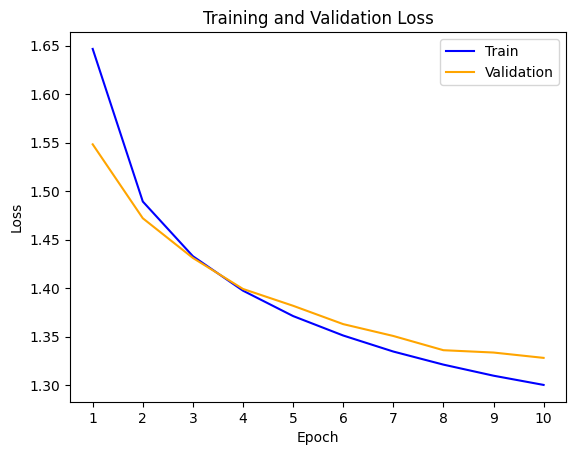

In [168]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [170]:
# test loss (showed no overfitting)
import torch.nn.functional as F
# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = 7

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in tqdm(test_loader):

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


100%|██████████| 113/113 [36:49<00:00, 19.55s/it]

Test Loss: 1.314458


In [171]:
classes =  ["Angry","Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [172]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

Angry	: 28% 	 (140/491)
Disgust	: 1% 	 (1/55)
Fear	: 29% 	 (155/528)
Happy	: 78% 	 (688/879)
Sad	: 35% 	 (211/594)
Surprise	: 62% 	 (260/416)
Neutral	: 54% 	 (344/626)

Test Accuracy of Dataset: 	 50% 	 (1799/3589)
